In [2]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
import numpy as np

from sklearn.pipeline import Pipeline

In [1]:
faces = fetch_lfw_people(min_faces_per_person=60)

In [2]:
print(faces.images.shape)

(1348, 62, 47)


In [3]:
print(faces.target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']


In [10]:
X = faces.data
y = faces.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

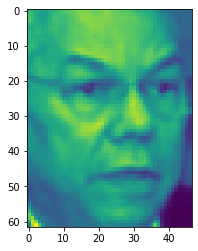

In [12]:
plt.imshow(faces.images[0])

In [15]:
n_components = 100
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [17]:
X_train_pca = pca.transform(X_train) 
X_test_pca = pca.transform(X_test) 
print(sum(pca.explained_variance_ratio_))

0.9182862798916176


In [19]:
svc = SVC(kernel='rbf', gamma='auto') 
svc.fit(X_train_pca, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
y_pred = svc.predict(X_test_pca)
print(confusion_matrix(y_test, y_pred, labels=range(len(faces.target_names))))

[[  7   1   0   7   0   0   0   0]
 [  0  46   0   8   0   0   0   0]
 [  0   1  22  10   0   0   0   0]
 [  0   2   0 139   0   0   0   0]
 [  0   0   0   8  19   0   0   3]
 [  0   4   0   4   0  11   0   0]
 [  0   0   0   2   0   0  15   1]
 [  0   0   0   7   0   0   0  20]]


In [23]:
print(classification_report(y_test, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.47      0.64        15
     Colin Powell       0.85      0.85      0.85        54
  Donald Rumsfeld       1.00      0.67      0.80        33
    George W Bush       0.75      0.99      0.85       141
Gerhard Schroeder       1.00      0.63      0.78        30
      Hugo Chavez       1.00      0.58      0.73        19
Junichiro Koizumi       1.00      0.83      0.91        18
       Tony Blair       0.83      0.74      0.78        27

         accuracy                           0.83       337
        macro avg       0.93      0.72      0.79       337
     weighted avg       0.86      0.83      0.82       337



## hyper parameters tuning
There is the parameter γ in the Gaussian kernel and the parameter C that controls the regularization for the SVM model. One could also have the kernel itself as a (qualitative) hyperparameter and the number of retained principal components in the PCA as another hyperparameter but this would make the grid search more difficult as the hyperparameters wouldn’t be independent anymore.

In [26]:
param_grid = {"C": np.logspace(-2, 3, 10), "gamma": np.logspace(-4, 1, 10)}
clf = GridSearchCV(SVC(kernel="rbf", gamma="auto"), param_grid, iid=False, cv=5)
clf = clf.fit(X_train_pca, y_train)

/Users/yunfei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [27]:
print(clf.best_estimator_)

SVC(C=21.544346900318846, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.004641588833612782, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)


In [28]:
y_pred = clf.predict(X_test_pca)
print(confusion_matrix(y_test, y_pred, labels=range(len(faces.target_names))))

[[ 12   2   0   1   0   0   0   0]
 [  1  51   0   1   0   0   0   1]
 [  1   1  28   2   0   0   0   1]
 [  0   6   4 130   0   0   1   0]
 [  0   0   0   2  23   0   0   5]
 [  0   4   0   1   1  13   0   0]
 [  1   0   0   0   0   0  17   0]
 [  0   1   0   0   1   0   0  25]]


In [30]:
print(classification_report(y_test, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.80      0.80      0.80        15
     Colin Powell       0.78      0.94      0.86        54
  Donald Rumsfeld       0.88      0.85      0.86        33
    George W Bush       0.95      0.92      0.94       141
Gerhard Schroeder       0.92      0.77      0.84        30
      Hugo Chavez       1.00      0.68      0.81        19
Junichiro Koizumi       0.94      0.94      0.94        18
       Tony Blair       0.78      0.93      0.85        27

         accuracy                           0.89       337
        macro avg       0.88      0.85      0.86       337
     weighted avg       0.90      0.89      0.89       337



In [31]:
print(accuracy_score(y_test, y_pred))

0.887240356083086


In [34]:
pca = PCA(whiten=True)
lin = SVC(kernel='rbf', gamma='auto')
pca_svc = Pipeline([("pca", pca), ("svc", svc)]) 
clf = GridSearchCV(
    estimator=pca_svc, 
    cv=5,
    iid=False, 
    param_grid=dict(
        pca__n_components=[80, 90, 100, 110], 
        svc__C=np.logspace(-2, 3, 2), 
        svc__gamma=np.logspace(-4, 1, 2),
    ), 
)

In [35]:
clf = clf.fit(X_train_pca, y_train)

/Users/yunfei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=110 must be between 0 and min(n_samples, n_features)=100 with svd_solver='full'

  FitFailedWarning)
/Users/yunfei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=110 must be between 0 and min(n_samples, n_features)=100 with svd_solver='full'

  FitFailedWarning)
/Users/yunfei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: n_components=110 must be between 0 and min(n_samples, n_fe

In [36]:
print(confusion_matrix(y_test, y_pred, labels=range(len(faces.target_names))))

[[ 12   2   0   1   0   0   0   0]
 [  1  51   0   1   0   0   0   1]
 [  1   1  28   2   0   0   0   1]
 [  0   6   4 130   0   0   1   0]
 [  0   0   0   2  23   0   0   5]
 [  0   4   0   1   1  13   0   0]
 [  1   0   0   0   0   0  17   0]
 [  0   1   0   0   1   0   0  25]]


In [37]:
print(clf.best_estimator_)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=100,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('svc',
                 SVC(C=1000.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.0001,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)


In [38]:
y_pred = clf.predict(X_test_pca)
print(confusion_matrix(y_test, y_pred, labels=range(len(faces.target_names))))

[[ 11   1   1   2   0   0   0   0]
 [  1  47   1   3   1   0   1   0]
 [  3   1  27   1   0   0   0   1]
 [  4  10   5 119   1   0   1   1]
 [  0   1   0   2  20   0   0   7]
 [  1   4   0   1   1  12   0   0]
 [  1   0   0   0   0   0  17   0]
 [  0   1   0   4   1   0   0  21]]


In [39]:
print(classification_report(y_test, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.52      0.73      0.61        15
     Colin Powell       0.72      0.87      0.79        54
  Donald Rumsfeld       0.79      0.82      0.81        33
    George W Bush       0.90      0.84      0.87       141
Gerhard Schroeder       0.83      0.67      0.74        30
      Hugo Chavez       1.00      0.63      0.77        19
Junichiro Koizumi       0.89      0.94      0.92        18
       Tony Blair       0.70      0.78      0.74        27

         accuracy                           0.81       337
        macro avg       0.80      0.79      0.78       337
     weighted avg       0.83      0.81      0.82       337



# paper
Chris J.C. Burges and Bernhard Schölkopf. “Improving the Accuracy and Speed of Support Vector Machines”. In: Advances in Neural Information Processing Systems 9. MIT Press, 1997, pp. 375–381.

In [14]:
a = np.array([[1,1,0],[4,5,0]])

In [11]:
a

array([[1, 1, 0],
       [4, 5, 0]])

In [12]:
def a
a[a > 0] = 1 

In [13]:
a

array([[1, 1, 0],
       [1, 1, 0]])

In [16]:
,

In [17]:
normalize_0_1(a)

array([[1, 1, 0],
       [1, 1, 0]])